# Predicting Copper Production with Synthetic Data: NN vs. XGBoost

We simulate a realistic mining dataset to predict copper production (`y`) from five process variables (`x1`–`x5`). Although XGBoost scores *slightly better* on standard metrics, a feedforward Neural Network is **more faithful to domain physics**: when ore tonnage increases (all else fixed), predicted copper must also increase. XGBoost’s stepwise, piecewise-constant response violates this, making it unreliable for extrapolation or process control.

---

## Motivation & Objective

- **Business/physics prior:** If all other operating conditions stay fixed, increasing ore feed should yield more copper.  
- **Question:** Which model better captures this *monotonic* relationship—Neural Networks (NN) or XGBoost (XGB)?  
- **Hypothesis:** Tree ensembles may show flat plateaus where predictions stop increasing, while an NN (properly regularized) can learn a smooth, monotonic-like mapping.

---

## Synthetic Data Generation

- **Samples:** 1,000
- **Features & Marginals:**
  - `x1` (Ore tonnage): log-normal  
  - `x2` (Cu head grade): truncated normal  
  - `x3` (Plant uptime/availability): beta (scaled)  
  - `x4` (SAG mill power): truncated normal  
  - `x5` (Air/collector rate): truncated normal
- **Target (`y`):** Non-linear function of all features + Gaussian noise to mimic measurement error.

---

## Exploratory Data Analysis

- **Scatter Matrix & Correlations:** Visual check of pairwise relations and linear correlations.  
- **Partial Dependence (1D PDPs):** For each feature, vary it across its range while holding others at their mean to inspect marginal effects on `y`.  
- **Feature Sweep on `x1`:** A special case to test the “more ore ⇒ more Cu” rule.

---

## Data Preparation

- Split: 90% train (with 10% validation) / 10% test  
- Scaling: `StandardScaler` on inputs (required for stable NN training; not for XGB)

---

## Models

### 1. Neural Network (Keras/TensorFlow)
- Architecture: 2 hidden layers (ReLU), linear output
- Loss: MSE, Optimizer: Adam  
- Training curves: Track train/val loss to monitor over/underfitting

### 2. XGBoost Regressor
- Hyperparameter search: `RandomizedSearchCV`  
- Best estimator chosen via cross-validated MSE

---

## Quantitative Comparison

Metrics on the **test set**:
- MSE, RMSE, MAE, $R^2$ (tabulated for both models)

> **Result:** XGB wins slightly on these aggregate metrics.  
> **But…**

---

## Interpretation Tools

- **PDPs for Both Models:** Compare functional shapes per feature  
- **Sweep Plots:** Overlay ground-truth function, NN predictions, and XGB predictions across `x1`

### What is a Partial Dependence Plot (PDP)?

A PDP shows the **average effect** of one (or a small set of) feature(s) on a model’s prediction.  
- **How it works:**  
  - Varies the feature(s) across their range  
  - Averages model predictions while keeping other features fixed at their mean values

- **Tells you:** Direction and shape (linear, monotonic, saturating, etc.) of the model’s response to that feature.  
- **Averages over others:** So it hides interactions; use ICE plots if you need individual curves.  

For more details and example, see:  
- [scikit-learn docs on partial dependence](https://scikit-learn.org/stable/modules/partial_dependence.html)
- [scikit-learn example on partial dependence](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html)

<div style="text-align: center;">
  <img src="pictures/pdp_model_comparison.png" alt="PDP Comparison" width="1000px"/>
</div>

---

## Results: Qualitative/Physics-Based Validation

<img src="pictures/pdpX1_model_comparison.png"
     alt="PDP X1 Comparison"
     width="400px"
     style="float: right; margin: 0 10px 10px 0;" />

- **Monotonicity Check (Feature Sweep on `x1`):**
  - NN predictions: Smooth, strictly increasing (with small oscillations permitted by noise)  
  - XGB predictions: Stepwise plateaus → sometimes *no increase* in predicted `y` despite higher `x1`

- **Conclusion:** The NN better encodes the expected physical behaviour. For decision support or what-if analysis (changing ore feed), *behavioural fidelity beats a fractional drop in MSE*.

## Key Takeaway

**Do not stop at metrics.** For process modelling, a model that obeys known physics/engineering rules is more trustworthy, even if it sacrifices a few points of $R^2$.

<div style="clear: both;"></div>


# packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import partial_dependence, plot_partial_dependence, PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from xgboost import XGBRegressor

# Data Creation

In [2]:
np.random.seed(42)
n_samples = 1_000

# ---- 1) Correlated normals -----------------------------------------------
rho = 0.08  # target rank‑correlation
corr = np.full((5, 5), rho)
np.fill_diagonal(corr, 1.0)
Z = np.random.multivariate_normal(mean=np.zeros(5), cov=corr, size=n_samples)

# ---- 2) Convert to uniforms ----------------------------------------------
U = st.norm.cdf(Z)  # shape (n_samples, 5)

# ---- 3) Impose realistic marginals ---------------------------------------

# x1 – ore tonnage, log‑normal
mu_ln, sigma_ln = math.log(2500), 0.30
x1 = st.lognorm(s=sigma_ln, scale=math.exp(mu_ln)).ppf(U[:, 0])

# x2 – head grade, truncated normal
grade_low, grade_high = 0.15, 1.50
mu2, sd2 = 0.60, 0.25
a2, b2 = (grade_low - mu2) / sd2, (grade_high - mu2) / sd2
x2 = st.truncnorm(a2, b2, loc=mu2, scale=sd2).ppf(U[:, 1])

# x3 – uptime, beta scaled to [0.8, 1]
alpha3, beta3 = 5, 1.5
x3 = 0.8 + 0.2 * st.beta(alpha3, beta3).ppf(U[:, 2])

# x4 – Mill power, truncated normal
pow_low, pow_high = 5, 25
mu4, sd4 = 15, 4.5
a4, b4 = (pow_low - mu4) / sd4, (pow_high - mu4) / sd4
x4 = st.truncnorm(a4, b4, loc=mu4, scale=sd4).ppf(U[:, 3])

# x5 – air/collector rate, truncated normal
air_low, air_high = 20, 120
mu5, sd5 = 60, 15
a5, b5 = (air_low - mu5) / sd5, (air_high - mu5) / sd5
x5 = st.truncnorm(a5, b5, loc=mu5, scale=sd5).ppf(U[:, 4])


df = pd.DataFrame(
    dict(x1=x1, x2=x2, x3=x3, x4=x4, x5=x5)
)

df.head()


/Users/sahargholipour/opt/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


,x1,x2,x3,x4,x5
0,2234.775017,0.878364,0.950426,10.799801,48.779405
1,3891.619341,0.489078,0.959037,11.360638,67.435944
2,2381.802952,0.327302,0.996748,18.335924,56.183814
3,2100.739890,0.553687,0.994671,17.831999,57.481302
4,1881.864789,0.220860,0.963112,13.166084,50.695169


## Generating signal

In [3]:
def cu_product(x1, x2, x3, x4, x5):
    
    return np.abs(
        x1
        + 0.2 * np.sin(x1)
        + 0.5 * (x2+2)**1.2
        + 0.3 * x3 * x4
        + 0.01 * x2 * x5
        + np.log(x4 + 2)**3
        + np.sqrt(np.abs(x5) + 1)
    )

signal = cu_product(
    df['x1'], df['x2'], df['x3'], df['x4'], df['x5']
)

# Add noise at ~15% of the signal's standard deviation
noise = np.random.normal(0, 0.15 * signal.std(), size=n_samples)

# Final target variable
df['y'] = signal + noise

print(df.describe().round(2))
df.head()

            x1       x2       x3       x4       x5        y
count  1000.00  1000.00  1000.00  1000.00  1000.00  1000.00
mean   2609.64     0.62     0.95    14.96    60.54  2640.38
std     823.15     0.22     0.03     4.22    14.46   837.28
min     798.28     0.16     0.84     5.04    21.73   817.77
25%    2029.30     0.46     0.94    11.71    50.35  2038.95
50%    2487.00     0.62     0.96    14.88    60.32  2521.18
75%    3058.51     0.78     0.98    18.06    70.62  3114.45
max    7220.54     1.35     1.00    24.94   107.05  7381.42


,x1,x2,x3,x4,x5,y
0,2234.775017,0.878364,0.950426,10.799801,48.779405,2211.135708
1,3891.619341,0.489078,0.959037,11.360638,67.435944,3866.512492
2,2381.802952,0.327302,0.996748,18.335924,56.183814,2201.913880
3,2100.739890,0.553687,0.994671,17.831999,57.481302,2101.596140
4,1881.864789,0.220860,0.963112,13.166084,50.695169,2004.936232


### Feature Analysis

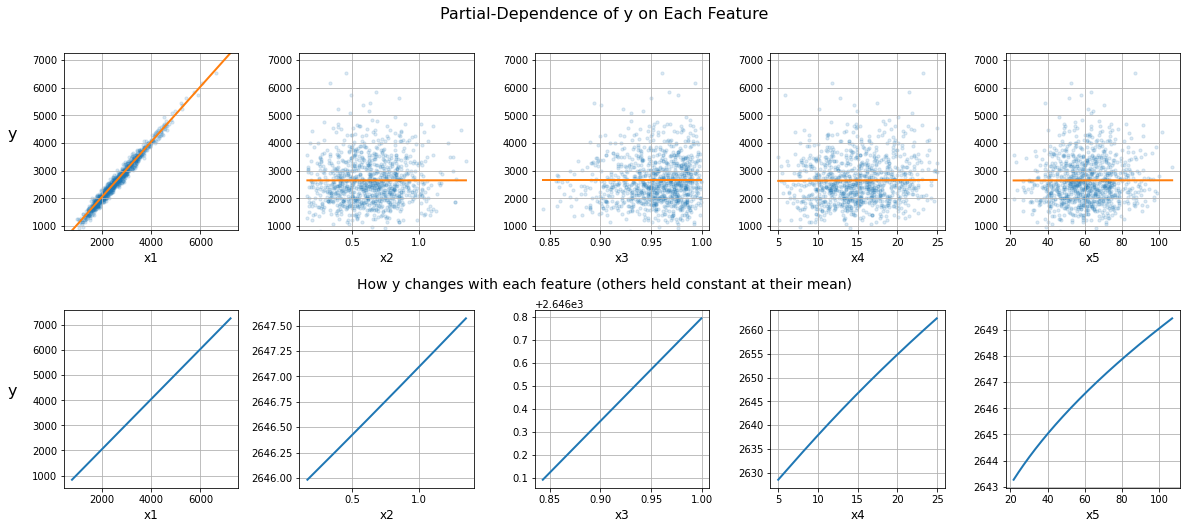

In [15]:
# Precompute the means
means = {col: df[col].mean() for col in ['x1','x2','x3','x4','x5']}

# Compute each partial‐dependence curve and find global y‐range
pdp = {}
ymins, ymaxs = [], []
for var in means:
    seq = np.linspace(df[var].min(), df[var].max(), 300)
    args = means.copy(); args[var] = seq
    y_pred = cu_product(**args)
    pdp[var] = (seq, y_pred)
    ymins.append(y_pred.min()); ymaxs.append(y_pred.max())

ymin, ymax = min(ymins), max(ymaxs)
vars_list = list(pdp.keys())
n = len(vars_list)

# Create 2×5 subplots
fig, axes = plt.subplots(
    2, n,
    figsize=(4*n, 8),
    sharey=False,
    gridspec_kw={
        'hspace': 0.45,
        'wspace': 0.35
    }
)

# Top row: scatter + PD curve, fixed y‐limits
for col, var in enumerate(vars_list):
    ax = axes[0, col]
    seq, y_pred = pdp[var]
    ax.scatter(df[var], df['y'], alpha=0.15, s=10)
    ax.plot(seq, y_pred, color='C1', lw=2)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(var, fontsize=12)
    if col == 0:
        ax.set_ylabel('y', fontsize=16, rotation=0, labelpad=20)
    ax.grid(True)

# Bottom row: curve only, auto‐scaled y‐limits
for col, var in enumerate(vars_list):
    ax = axes[1, col]
    seq, y_pred = pdp[var]
    ax.plot(seq, y_pred, color='C0', lw=2)
    ax.set_xlabel(var, fontsize=12)
    if col == 0:
        ax.set_ylabel('y', fontsize=16, rotation=0, labelpad=20)
    ax.grid(True)


fig.suptitle('Partial‐Dependence of y on Each Feature', fontsize=16, y=0.96)
# place a row title centered above the bottom row
fig.text(
    0.5, 0.47,
    'How y changes with each feature (others held constant at their mean)',
    ha='center',
    fontsize=14
)

plt.savefig("pictures/pdp_comparison.png", bbox_inches="tight", facecolor="white", transparent=False)
plt.show()


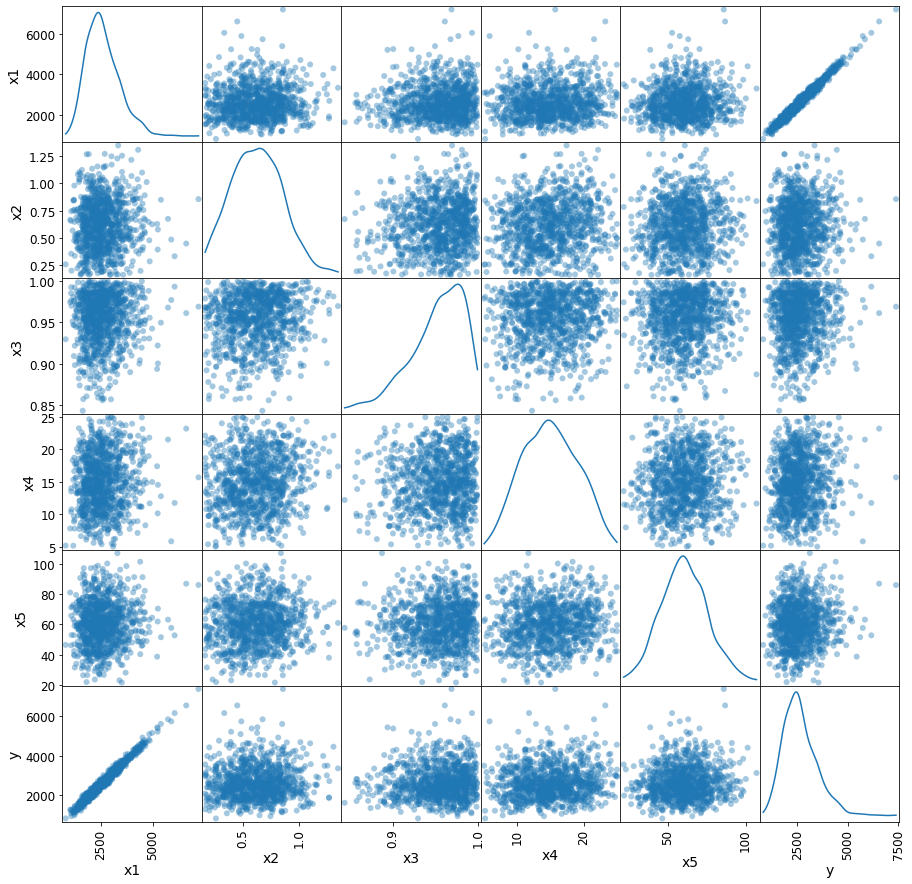

In [ ]:
# Plot the scatter matrix
axes = pd.plotting.scatter_matrix(
    df,
    figsize=(15, 15),
    alpha=0.4,
    diagonal='kde',
    marker='o'
)

# Increase font sizes for labels and ticks
for ax in axes.flatten():
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.tick_params(axis='both', labelsize=12)
    

plt.show()

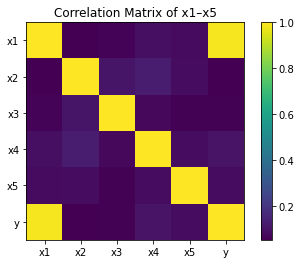

In [61]:
# correlation matrix
corr = df.corr()

# Plot the correlation matrix
fig, ax = plt.subplots()
cax = ax.matshow(corr)
fig.colorbar(cax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Move x‑axis ticks to bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.tick_bottom()

plt.title('Correlation Matrix of x1–x5')
plt.show()


# Model Training

## Spliting Data

In [6]:
# Convert the date
np_data = df.to_numpy().astype(float)

# Extract the features and target variable
X_data = np_data[:, :-1]
Y_data = np_data[:, -1]

print("\nFeatures before scaling :\n------------------------------------")
print(X_data[:5,:])
print("\nTarget:\n------------------------------------")
print(Y_data[:5])

# # Create a scaler model that is fit on the input data.
# scaler = StandardScaler().fit(X_data)

# # Scale the feature variables
# X_data = scaler.transform(X_data)
# print("\nFeatures after scaling :\n------------------------------------")
# print(X_data[:5,:])

#Split training and test data
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.10, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)
print("\nFeatures after scaling (training set):\n------------------------------------")
print(X_train_s[:5,:])

print("\nTrain Test Dimensions:\n------------------------------------")
print(X_train_s.shape, Y_train.shape, X_test_s.shape, Y_test.shape)


Features before scaling :
------------------------------------
[[2.23477502e+03 8.78364010e-01 9.50425630e-01 1.07998011e+01
  4.87794050e+01]
 [3.89161934e+03 4.89078231e-01 9.59036719e-01 1.13606381e+01
  6.74359440e+01]
 [2.38180295e+03 3.27301609e-01 9.96748436e-01 1.83359238e+01
  5.61838144e+01]
 [2.10073989e+03 5.53687321e-01 9.94670885e-01 1.78319987e+01
  5.74813021e+01]
 [1.88186479e+03 2.20859992e-01 9.63112476e-01 1.31660840e+01
  5.06951693e+01]]

Target:
------------------------------------
[2211.13570808 3866.5124919  2201.91387997 2101.59614019 2004.93623154]

Features after scaling (training set):
------------------------------------
[[-0.07835677 -1.90257828  0.10001792 -2.24413785 -0.60520647]
 [-0.78795285  0.81140853 -1.76639608 -1.85068288 -0.09346486]
 [-0.44748633 -0.24731706  1.36502022 -0.6309834  -0.04634911]
 [-0.30050229  0.84359307  0.64632558 -0.63391923 -0.86069184]
 [-0.82181279  1.55998407  0.0211667   0.88858888  0.62589361]]

Train Test Dimensions:


## Nueral Network

2025-07-27 11:04:44.061095: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 11:04:44.064514: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense-Layer-1 (Dense)        (None, 128)               768       
_________________________________________________________________
Dense-Layer-2 (Dense)        (None, 128)               16512     
_________________________________________________________________
Final (Dense)                (None, 1)                 129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________

Training Progress:
------------------------------------
Train on 720 samples, validate on 180 samples
Epoch 1/30
720/720 [==============================] - 1s 1ms/sample - loss: 7733374.8222 - rmse: 2780.8948 - val_loss: 6871268.8333 - val_rmse: 2621.3105
Epoch 2/30
720/720 [==============================] - 0s 81us/sample - loss: 7272308.6444 - rmse: 2696.7217 - val_loss: 59659

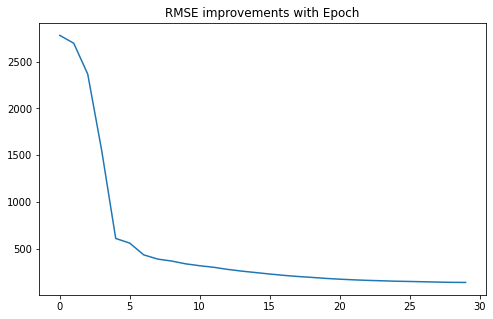


Evaluation against Test Dataset :
------------------------------------
100/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[18365.09255859375, 135.51787]

In [7]:
# Setup Trraining Parameters
epoch = 30
batch_size = 64
verbose = 1
n_hidden = 128
# 20% of the training data will be used for validationafter each epoch
validation_split = 0.2

# Create Keras sequential model
model = keras.Sequential()
# Add a Dense Layer
model.add(keras.layers.Dense(
    n_hidden, name='Dense-Layer-1', activation='relu', input_shape=(X_train_s.shape[1],)
))

# Add a second dense layer
model.add(keras.layers.Dense(
    n_hidden, name='Dense-Layer-2', activation='relu'
))

# Add a linear layer for regression prediction
model.add(keras.layers.Dense(1,
                             name='Final',
                             activation='linear'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.01),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Print the model meta-data
model.summary()


print("\nTraining Progress:\n------------------------------------")

# Fit the model. This will perform the entire training cycle, including
# forward propagation, loss computation, backward propagation and gradient descent.
# Execute for the specified batch sizes and epoch
# Perform validation after each epoch 
history=model.fit(X_train_s,
          Y_train,
          batch_size=batch_size,
          epochs=epoch,
          verbose=verbose,
          validation_split=validation_split)

print("\nAccuracy during Training :\n------------------------------------")


# Plot accuracy of the model after each epoch.
pd.DataFrame(history.history)['rmse'].plot(figsize=(8, 5))
plt.title("RMSE improvements with Epoch")
plt.show()

# Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test_s,Y_test)

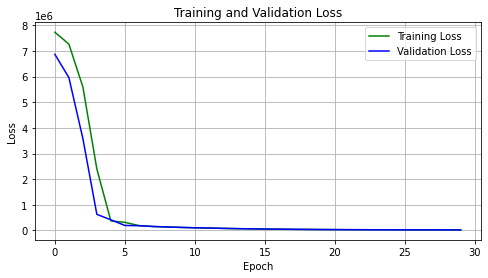

In [8]:
# plot the loss function for training and validation
def plot_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], 'g', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    

plot_loss(history)

## XGBoost

In [9]:
# finding the best hyperparameters for XGBoost
# Define the parameter grid for RandomizedSearchCV
param_grid = {'max_depth': [4,5,6,7],
              'n_estimators': [100,500,600,700, 1000],
              'learning_rate': [0.01,0.015,0.3]}


rand_cv = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=1),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=1
)
rand_cv.fit(X_train, Y_train)
print("Best params:", rand_cv.best_params_)
xgb = rand_cv.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.015, max_depth=7, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.015, max_depth=7, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.015, max_depth=7, n_estimators=1000; total time=   0.8s
[CV] END ...learning_rate=0.3, max_depth=4, n_estimators=500; total time=   0.3s
[CV] END ...learning_rate=0.3, max_depth=4, n_estimators=500; total time=   0.3s
[CV] END ...learning_rate=0.3, max_depth=4, n_estimators=500; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=600; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=600; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=600; total time=   0.3s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=700; total time=   0.4s
[CV] END ...learning_rate=0.3, max_depth=5, n_estimators=700; total time=   0.4s
[CV] END ...learning_rate=0.3, max_depth=5, n_e

In [10]:
# Get predictions on the test set
y_pred_xgb = xgb.predict(X_test)
y_pred_nn = model.predict(X_test_s).flatten()

# Compute metrics for each model
results = []
for name, y_pred in [('XGBoost', y_pred_xgb), ('NeuralNet', y_pred_nn)]:
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    results.append({
        'Model': name,
        'MSE':   mse,
        'RMSE':  rmse,
        'MAE':   mae,
        'R2':    r2
    })

# Tabulate
metrics_df = pd.DataFrame(results).set_index('Model')
print(metrics_df)


                    MSE        RMSE         MAE        R2
Model                                                    
XGBoost    15368.601957  123.970166   96.247576  0.976453
NeuralNet  18365.094179  135.517874  106.061884  0.971862


# Model Comparison

/Users/sahargholipour/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


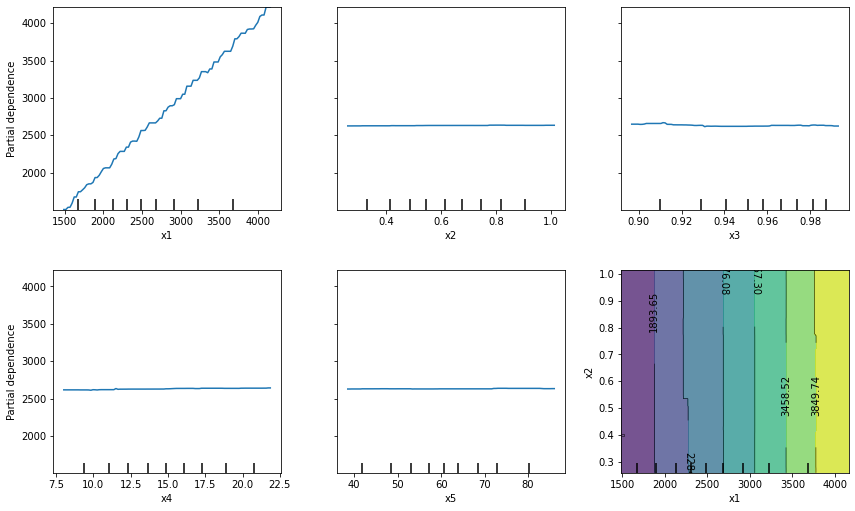

In [17]:
# plot pdp for xgb
plot_partial_dependence(
    xgb,
    X_train,
    features=[0, 1, 2, 3, 4, (0, 1)],
    feature_names=['x1','x2','x3','x4','x5', ('x1', 'x2')],
    n_jobs=6,
    grid_resolution=100,
    # n_cols = 6
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
fig.tight_layout(rect=[0,0.05,1,0.95])

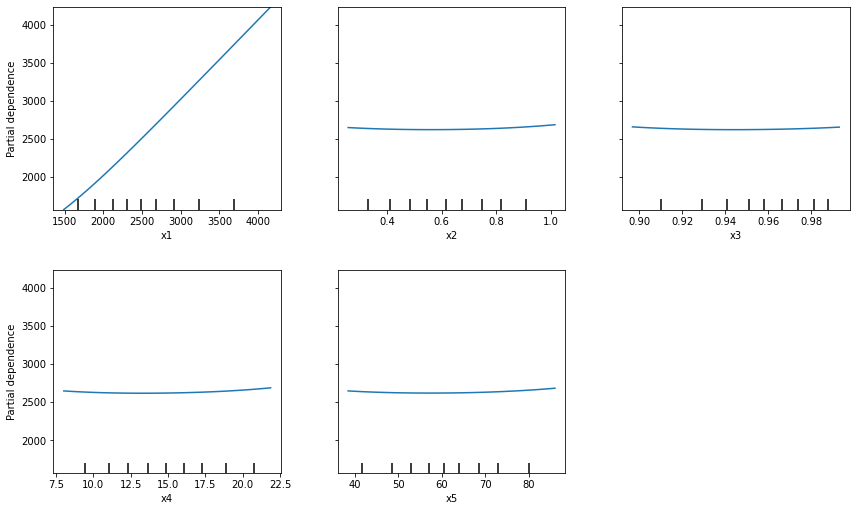

In [18]:
# plot pdp for nn
# Prepare a DataFrame so we have feature names
features = ['x1','x2','x3','x4','x5']
X_train_df = pd.DataFrame(X_train, columns=features)

# Wrapper that applies the scaler then calls the Keras model
class NNWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def fit(self, X, y):
        # Mark fitted so sklearn won’t complain
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        arr = X.values if hasattr(X, "values") else X
        scaled = self.scaler.transform(arr)
        return self.model.predict(scaled).flatten()

# Instantiate & “fit” (no training happens here)
nn_wrap = NNWrapper(model, scaler)
nn_wrap.fit(X_train_df, Y_train)

# Plot PDP
plot_partial_dependence(
    nn_wrap,
    X_train_df,
    features,
    n_jobs=1,
    grid_resolution=100
)

fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
plt.tight_layout(rect=[0,0.05,1,0.95])
plt.show()


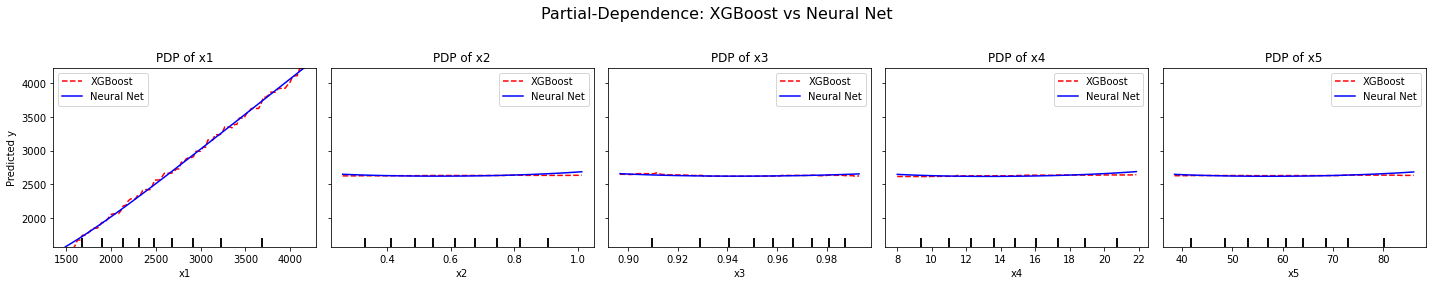

In [28]:
# Create a row of subplots, one per feature
fig, axes = plt.subplots(
    1, len(features),
    figsize=(4*len(features), 4),
    sharey=True
)

# Plot XGBoost PDP (dashed red lines)
PartialDependenceDisplay.from_estimator(
    xgb,
    X_train_df,
    features,
    ax=axes,
    grid_resolution=100,
    line_kw={'color':'red',    'linestyle':'--', 'label':'XGBoost'}
)

# Plot NN PDP (solid blue lines) on the same axes
PartialDependenceDisplay.from_estimator(
    nn_wrap,
    X_train_df,
    features,
    ax=axes,
    grid_resolution=100,
    line_kw={'color':'blue',   'linestyle':'-',  'label':'Neural Net'}
)

# Tidy up
for ax, feat in zip(axes, features):
    ax.set_title(f"PDP of {feat}")
    ax.set_xlabel(feat)
    if ax is axes[0]:
        ax.set_ylabel("Predicted y")
    else:
        ax.set_ylabel("")
    ax.legend()

fig.suptitle("Partial‑Dependence: XGBoost vs Neural Net", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("pictures/pdp_model_comparison.png", bbox_inches="tight", facecolor="white", transparent=False)
plt.show()


/Users/sahargholipour/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


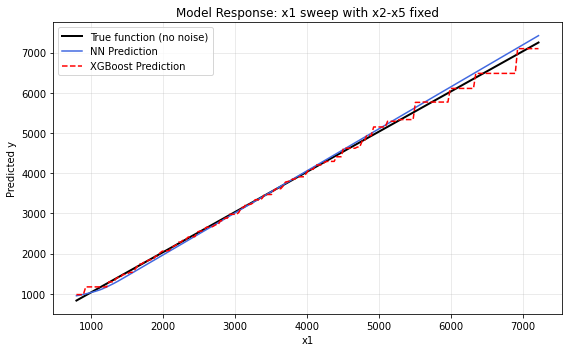

In [27]:
x1_const, x2_const, x3_const, x4_const, x5_const = [
    means[col] for col in ['x1','x2','x3','x4','x5']
]

# Sweep x1 from min to max in the dataset
x1_range = np.linspace(df['x1'].min(), df['x1'].max(), 200)

# Create input DataFrame for predictions
X_sweep = pd.DataFrame({
    'x1': x1_range,
    'x2': x2_const,
    'x3': x3_const,
    'x4': x4_const,
    'x5': x5_const
})

# NN requires scaled features
X_sweep_scaled = scaler.transform(X_sweep)

# Model predictions
y_nn = model.predict(X_sweep_scaled)
y_xgb = xgb.predict(X_sweep)

# True function (no noise) for reference
signal_true = np.abs(
    X_sweep['x1']
    + 0.2 * np.sin(X_sweep['x1'])
    + 0.5 * x2_const**1.2
    + 0.3 * x3_const * x4_const
    - 0.1 * x2_const * x5_const
    + np.log(x4_const + 2)**3
    + np.sqrt(np.abs(x5_const) + 1)
)

plt.figure(figsize=(8,5))
plt.plot(x1_range, signal_true, label='True function (no noise)', linewidth=2, color='black')
plt.plot(x1_range, y_nn, label='NN Prediction', linestyle='-', color='royalblue')
plt.plot(x1_range, y_xgb, label='XGBoost Prediction', linestyle='--', color='red')
plt.xlabel('x1')
plt.ylabel('Predicted y')
plt.title('Model Response: x1 sweep with x2-x5 fixed')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("pictures/pdpX1_model_comparison.png", bbox_inches="tight", facecolor="white", transparent=False)
plt.show()
